### Run these first!

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(900)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.1.0 ──

✔ broom        1.0.5     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.2.0
✔ recipes      1.0.6     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Introduction

Heart disease is typically diagnosed through an angiogram, an xray that looks at the heart, major arteries and blood vessels. An angiogram is expensive, ranging from 675 CAD - 2200 CAD. What if there was an easier and less costly way to diagnose heart disease?

In this project we look at attributes that can be derived from a simple routine checkup and blood test: blood pressure, cholesterol levels, age, and maximum heart rate, to diagnose heart disease. Specifically, we ask: Can we use blood pressure, cholesterol levels, age, and maximum heart rate to determine if a patient has heart disease?

The dataset used looks at 76 different attributes, 14 of which were used by researchers for data analysis. These vary from identifiers like age or sex to max heart rate to fasting blood sugar levels. Additionally they used datasets from 4 different locations: Cleveland, Hungary, Switzerland, and the VA Long Beach. In our analysis we combined the Cleveland and Hungary datasets. 


### Methods

The variables of importance for our analysis were age, resting blood pressure, cholesterol levels, and maximum heart rate. As observations for these variables can be obtained cheaply, and they appear to have some correlation to the presence of heart disease. 

We will display the correlations between our variables and heart disease through tables and scatterplots. It's important to use correlated variables because if variable x is correlated to variable y, it's very likely for there to be more variable y if we have lots of variable x.

### Preliminary exploratory data analysis 

---



In [2]:
#reads the raw data sets and converts them into tibbles with no column names
cleveland_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.cleveland.data',
                             col_names = FALSE) |> as_tibble()
hungarian_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.hungarian.data',
                             col_names = FALSE) |> as_tibble()

#combines the two data sets into one
heart_data <- rbind(cleveland_data, hungarian_data)

#assigns names to the columns based on information from the website
colnames(heart_data) <- c('age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'max_hr', 
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num') 

#In the Cleveland data set, presence of heart disease is ranked on a 1-4 scale, for our work, we dont need the scale,
#we only need 0 = no heart disease, 1 = heart disease present. This code converts all num values > 1 (heart disease present) to 1
heart_data <- mutate(heart_data, num = replace(num, num > 0, 1))

#converts all categorical attributes into factors
heart_data <- mutate(heart_data, sex = as.factor(sex), chest_pain = as.factor(chest_pain), 
    num = as.factor(num), fbs = as.factor(fbs), restecg = as.factor(restecg), 
    exang = as.factor(exang), thal = as.factor(thal), slope = as.factor(slope), ca = as.factor(ca)) |>

#removes missing values from the cholesterol and resting blood pressure columns
filter(chol != '?', trestbps != '?') |>

#converts all necessary numerical attributes into doubles
mutate(chol = as.double(chol), trestbps = as.double(trestbps), max_hr = as.double(max_hr))

#splits data into testing and training sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

head(heart_train)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age sex chest_pain trestbps chol fbs restecg max_hr exang oldpeak slope ca 
1 63  1   1          145      233  1   2       150    0     2.3     3     0.0
2 57  0   4          120      354  0   0       163    1     0.6     1     0.0
3 57  1   4          140      192  0   0       148    0     0.4     2     0.0
4 44  1   2          120      263  0   0       173    0     0.0     1     0.0
5 52  1   3          172      199  1   0       162    0     0.5     1     0.0
6 57  1   3          150      168  0   0       174    0     1.6     1     0.0
  thal num
1 6.0  0  
2 3.0  0  
3 6.0  0  
4 7.0  0  
5 7.0  0  
6 3.0  0

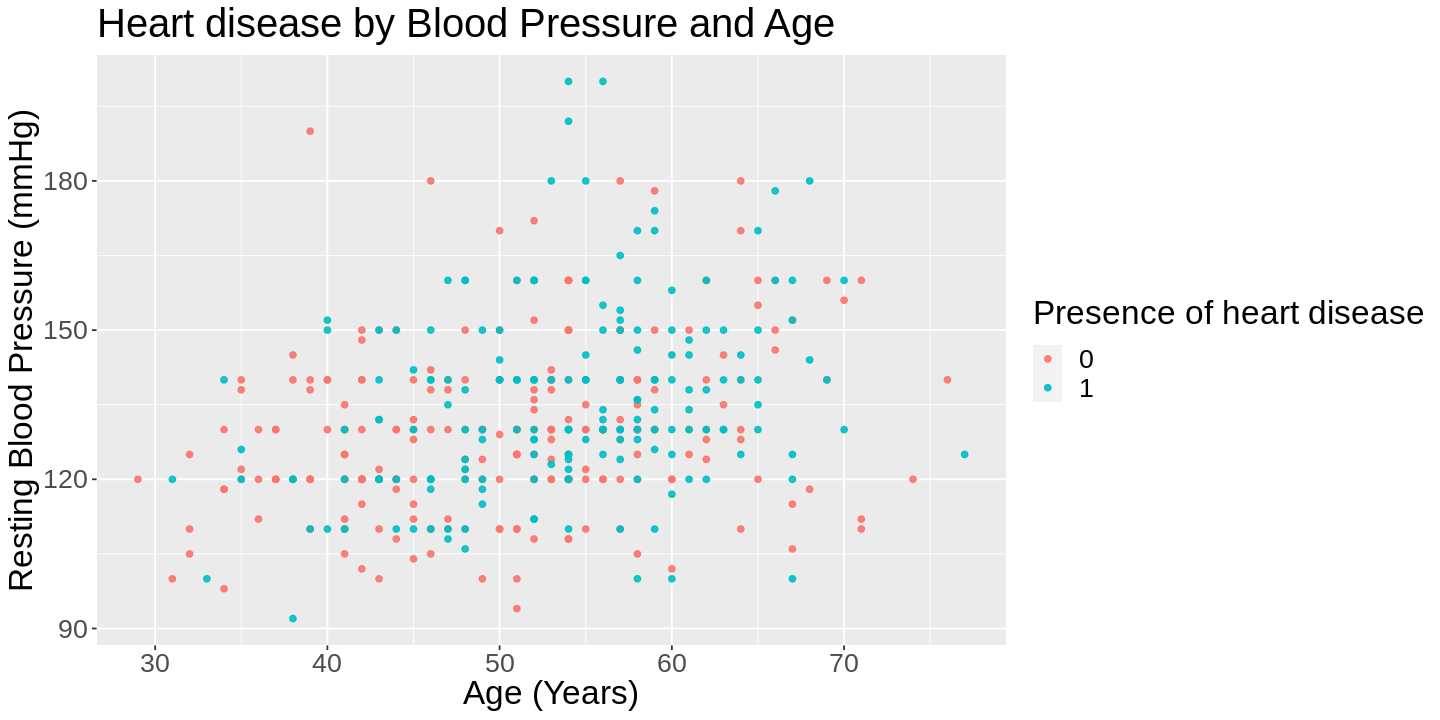

In [3]:
options(repr.plot.width = 12, repr.plot.height = 6)
heart_plot_age_bps <- heart_train |>
                ggplot(aes(x = trestbps, y = age, color = num)) +
                geom_point(alpha = 0.9) +
                theme(text = element_text(size = 20)) +
                labs (x = 'Resting Blood Pressure (mmHg)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Heart disease by Blood Pressure and Age") +
                coord_flip()
heart_plot_age_bps

This scatterplot shows the correlations between resting blood pressure (y axis) and age (x axis) to heart disease (color of the points). Generally, it can be seen that as age increases, resting blood pressure increases, and that there is a higher presence of heart disease in older individuals with higher resting blood pressures. This is a weak positive correlation.

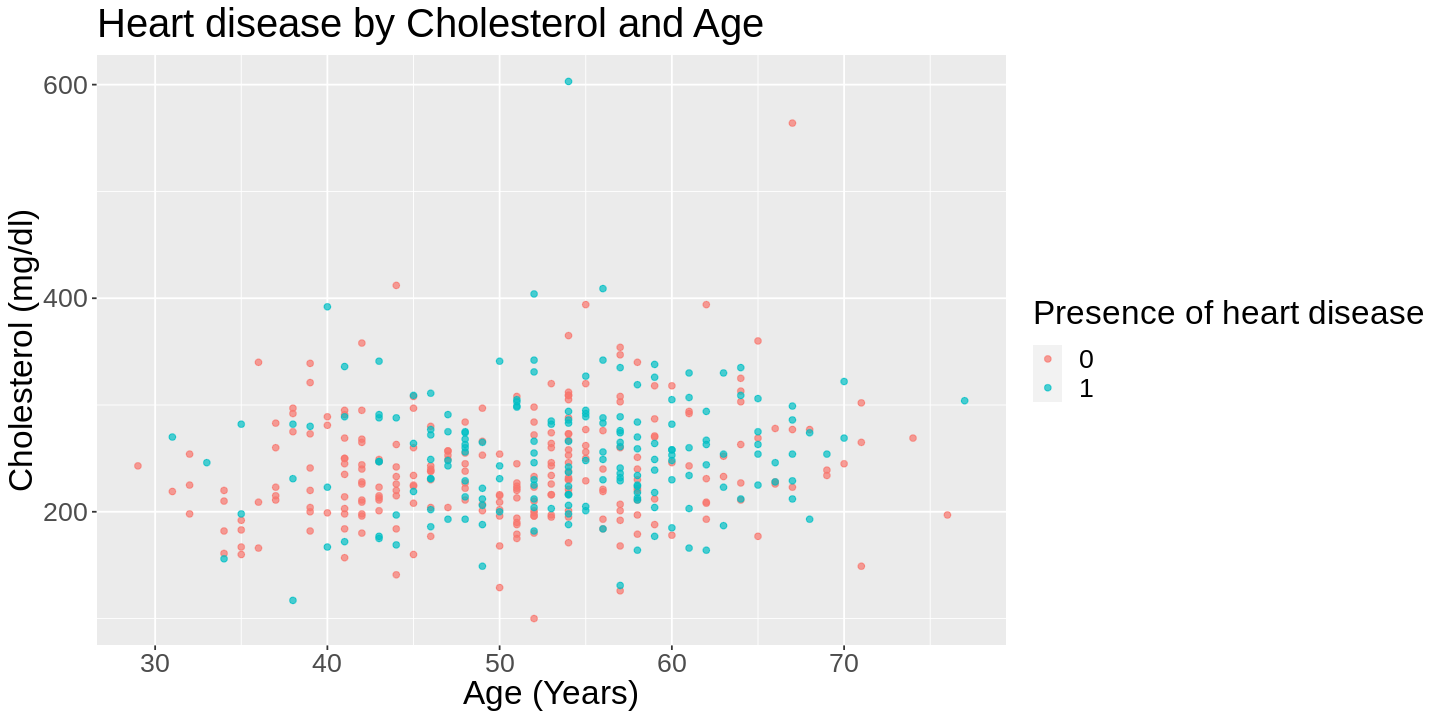

In [4]:
heart_plot_age_chol <- heart_train |>
                ggplot(aes(x = chol, y = age, color = num)) +
                geom_point(alpha = 0.7) +
                theme(text = element_text(size = 20)) +
                labs (x = 'Cholesterol (mg/dl)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Heart disease by Cholesterol and Age") +
                coord_flip()
heart_plot_age_chol

This scatterplot shows the correlations between cholesterol levels (y axis) and age (x axis) to heart disease (color of the points). Generally, it can be seen that as age increases, cholesterol levels slightly increase as well, and that there is a higher presence of heart disease in older individuals with higher cholesterol levels. This is a weak positive correlation.

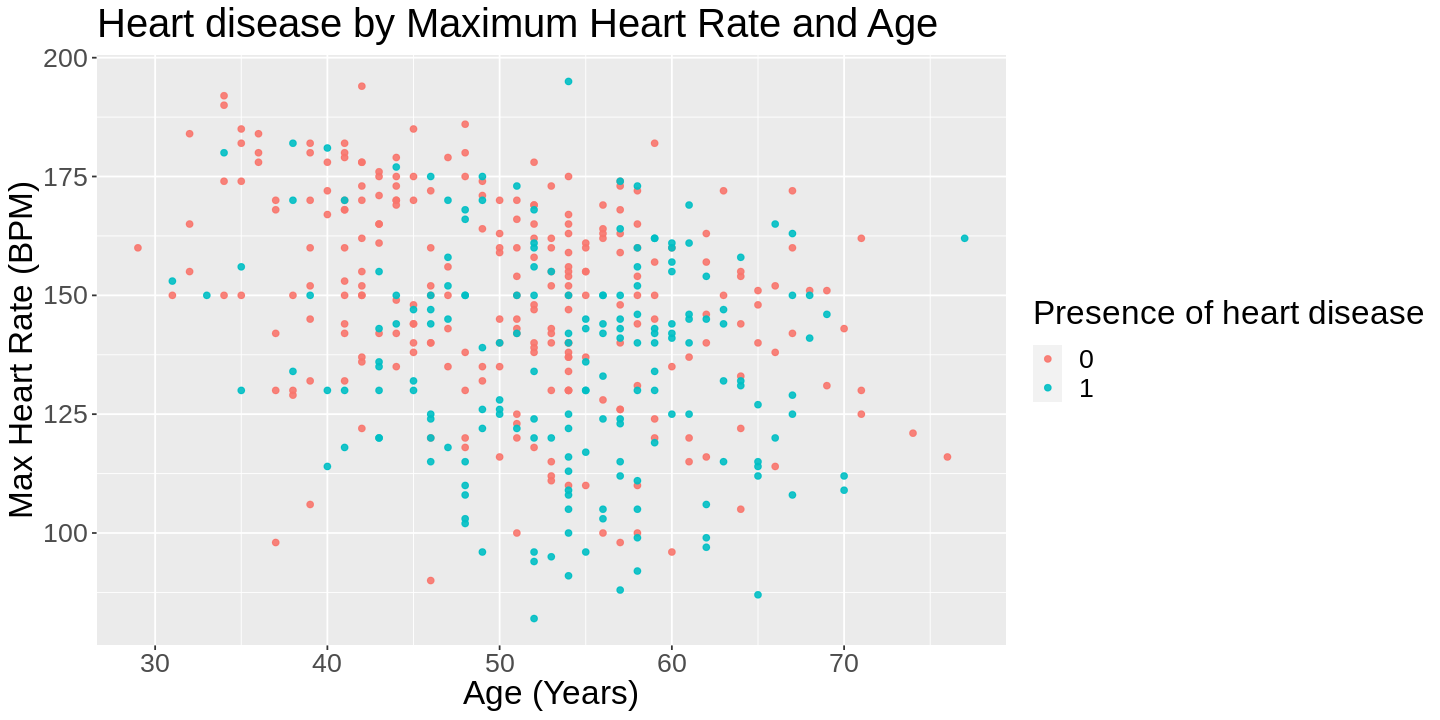

In [5]:
heart_plot_age_maxhr <- heart_train |>
                ggplot(aes(x = max_hr, y = age, color = num)) +
                geom_point(alpha = 0.9) +
                theme(text = element_text(size = 20)) +
                labs (x = 'Max Heart Rate (BPM)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Heart disease by Maximum Heart Rate and Age") +
                coord_flip()
heart_plot_age_maxhr

This scatterplot shows the correlations between maximum heart rate (y axis) and age (x axis) to heart disease (color of the points). Generally, it can be seen that as age increases, max heart rate decreases, and that there is a higher presence of heart disease in older individuals with smaller max heart rates. This is a weak negative correlation.

 As it can be seen, each variable is only weakly correlated to heart disease on its own. The goal of this project is to see if the *combination* of each of these variables is enough to predict if a patient has heart disease. 

### Expected Outcomes and Significance

Based on some preliminary research, we expect to find some relationship between heart disease and blood pressure, where high blood pressure indicates an increased risk for heart disease diagnosis. We also expect to see cholesterol being related to heart disease diagnosis, with high cholseterol levels indicating an increase risk for heart disease diagnosis. Maximum heart rate appears to be related to heart disease, with people that have lower max heart rates being more likely to have heart disease. Age has been linked to all four, with higher ages indictating increased risk for high blood pressure, high cholesterol, low maximum heart rate, and presence of heart disease. We are testing to see if we can predict whether a patient has heart disease based purely off of these variables, which are cheap to test for.

The impact is clear: if we can diagnose heart disease used other indicators aside from an angiogram, it means less costly procedure for physicians and patients, leading to increased access to heart disease diagnosis.

Future questions may allow us to rethink current standard diagnosis practices in medicine and explore easier, less expensive options. If this project is successful, one possible question is *"What other variables can we use to successfully predict heart disease with even more accuracy?"*